<a href="https://colab.research.google.com/github/jevais/qiskit_hackathon_kor_2022_team_daejeon_noisyqnn/blob/main/qnn_test1_noisymodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit_machine_learning
!pip install qiskit[visualization]

# Fashion MINST classification with qnn

necessary imports: we will use qiskit torch connector.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import torch.optim as optim
import torch.nn.functional as F

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss, NLLLoss
from torch.optim import LBFGS

from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
    CrossEntropyLoss,
    MSELoss
)


from qiskit import Aer, QuantumCircuit, IBMQ
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation, PauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.visualization import plot_histogram
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer.noise import NoiseModel

# Set seed for random generators
algorithm_globals.random_seed = 42

Load personal qiskit account

In [3]:
# mingi IBMQ account

IBMQ.save_account('e19e4ad4e9ed07b4987476bf3ff3e146834a78d5e063675ed311cec95e7f47fe69df1739bc0c84c7cb164b23cc54fb0a03a98e8f1876828b40c66d0d59e83d31', overwrite = True )
provider = IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
qasm_sim = provider.backend.ibmq_qasm_simulator
statevec_sim = provider.backend.simulator_statevector
vigo = FakeVigo()


seed = 20

qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))  # local simulator for test

# simulators in ibmq cloud service
qasm_qi = QuantumInstance(qasm_sim, basis_gates=['cx', 'id', 'rz', 'sx', 'x'], seed_transpiler=seed, seed_simulator=seed)
vec_qi = QuantumInstance(statevec_sim, basis_gates=['cx', 'id', 'rz', 'sx', 'x'], seed_transpiler=seed, seed_simulator=seed)
noise_model = NoiseModel.from_backend(vigo)     # noisy model 
noisy_qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"),  basis_gates=['cx', 'id', 'ry', 'p', 'x', 'h'] , noise_model= noise_model)  # noisy simulator for test

In [ ]:
{('h', 1), ('save_expval', 2), ('ry', 1), ('cx', 2), ('p', 1)}

# Load fashion MINST data for the training and the test

In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(( 0.5), ( 0.5))])

# Download and load the training data
trainset = datasets.FashionMNIST('./input/F_MNIST_data/', download=True, train=True, transform=transform)

# Download and load the test data
testset = datasets.FashionMNIST('./input/F_MNIST_data/', download=True, train=False, transform=transform)



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./input/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./input/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./input/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./input/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./input/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./input/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./input/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./input/F_MNIST_data/FashionMNIST/raw



In [19]:
class Sampler_for_MNIST(torch.utils.data.sampler.Sampler):
    def __init__(self, mask, data_source):
        self.mask = mask
        self.data_source = data_source

    def __iter__(self):
        return iter([i.item() for i in torch.nonzero(self.mask)])

    def __len__(self):
        return len(self.data_source)

#mask_train = (trainset.train_labels == 0) | (trainset.train_labels == 1).int()
mask_train = [1 if (trainset[i][1] == 0) | (trainset[i][1] == 1) else 0 for i in range(len(trainset))]
mask_train = torch.tensor(mask_train)

#mask_test = (testset.test_labels == 0) | (testset.test_labels == 1).int()
mask_test = [1 if (testset[i][1] == 0) | (testset[i][1] == 1) else 0 for i in range(len(testset))]
mask_test = torch.tensor(mask_test)

sampler_train = Sampler_for_MNIST(mask_train,trainset)
sampler_test = Sampler_for_MNIST(mask_test,testset)


In [20]:
batch_size0 = 16
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size0, sampler=sampler_train, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size0, sampler=sampler_test, shuffle=False)

In [7]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [12]:
# Define QNN
feature_map = ZZFeatureMap(2)
ansatz = RealAmplitudes(2, reps=1)
# REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
qnn4 = TwoLayerQNN(
    2, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi   ### 로컬 시뮬레이터가 아닌 실제 IBM 디바이스에 서킷 넣을 땐 oplow.PauliExpectation 을 넣자
)

qnn4_noisy = TwoLayerQNN(
    2, feature_map, ansatz, input_gradients=True, exp_val=PauliExpectation(), quantum_instance=noisy_qi   ### noisy qnn
)

print(qnn4_noisy.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])


In [21]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=5)
        self.conv2 = nn.Conv2d(2, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn4)  # Apply torch connector, weights chosen
        self.fc3 = nn.Linear(1, 1)  # 1-dimensional output from QNN
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x.view(-1)
    
model = Classifier()    

In [22]:
epochs = 5
steps = 0
Ntrain_data = 10;
Ntest_data = 20;

In [23]:
criterion = nn.MSELoss()
#criterion = nn.NLLLoss()
def lr_model(x):
  return np.exp(-x)

optimizer = optim.Adam(model.parameters(), lr=0.005)


train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    j = 0
    for i, (images, labels) in enumerate(train_loader):        
        
        if  j < Ntrain_data:
            
            optimizer.zero_grad()

            output = model(images).float()
            loss = criterion(output, labels.float())
            loss.backward()
            optimizer.step()
            #print('calculation .... ')

            running_loss += loss.item()
            j=j+1

    else:
        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            j=0
            accuracy=0
            for i, (images, labels) in enumerate(test_loader):
                
                #print('now test...')
                if  j < Ntest_data:
                    output = model(images).float()
                    test_loss += criterion(output, labels.float())
                    
                    refine_output = torch.round(output)
                    
                    accuracy=accuracy+torch.sum(refine_output-labels==0)
                                     
                    j=j+1

        train_losses.append(running_loss/Ntrain_data)
        test_losses.append(test_loss/Ntest_data)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/Ntrain_data),
              "Test Loss: {:.3f}.. ".format(test_loss/Ntest_data),
              "Test Accuracy: {:.3f}".format(accuracy/(Ntest_data*batch_size0)))

Epoch: 1/5..  Training Loss: 0.222..  Test Loss: 0.200..  Test Accuracy: 0.500
Epoch: 2/5..  Training Loss: 0.179..  Test Loss: 0.177..  Test Accuracy: 0.659
Epoch: 3/5..  Training Loss: 0.169..  Test Loss: 0.167..  Test Accuracy: 0.716
Epoch: 4/5..  Training Loss: 0.152..  Test Loss: 0.145..  Test Accuracy: 0.894
Epoch: 5/5..  Training Loss: 0.143..  Test Loss: 0.132..  Test Accuracy: 0.928


In [13]:
class noisyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=5)
        self.conv2 = nn.Conv2d(2, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn4_noisy)  # Apply torch connector, weights chosen
        self.fc3 = nn.Linear(1, 1)  # 1-dimensional output from QNN
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply noisy QNN
        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x.view(-1)
    
model_noisy = noisyClassifier()    

In [14]:
epochs = 5
steps = 0
Ntrain_data = 10;
Ntest_data = 20;

In [15]:
criterion = nn.MSELoss()
#criterion = nn.NLLLoss()
optimizer = optim.Adam(model_noisy.parameters(), lr=0.005)


train_losses_noisy, test_losses_noisy = [], []
for e in range(epochs):
    running_loss = 0
    j = 0
    for i, (images, labels) in enumerate(train_loader):        
        
        if  j < Ntrain_data:
            
            optimizer.zero_grad()

            output = model_noisy(images).float()
            loss = criterion(output, labels.float())
            loss.backward()
            optimizer.step()
            #print('calculation .... ')

            running_loss += loss.item()
            j=j+1

    else:
        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            j=0
            accuracy=0
            for i, (images, labels) in enumerate(test_loader):
                
                if  j < Ntest_data:
                    output = model_noisy(images).float()
                    test_loss += criterion(output, labels.float())
                    
                    refine_output = torch.round(output)
                    
                    accuracy=accuracy+torch.sum(refine_output-labels==0)
                                     
                    j=j+1

        train_losses_noisy.append(running_loss/Ntrain_data)
        test_losses_noisy.append(test_loss/Ntest_data)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/Ntrain_data),
              "Test Loss: {:.3f}.. ".format(test_loss/Ntest_data),
              "Test Accuracy: {:.3f}".format(accuracy/(Ntest_data*batch_size0)))

Epoch: 1/5..  Training Loss: 0.258..  Test Loss: 0.249..  Test Accuracy: 0.500
Epoch: 2/5..  Training Loss: 0.246..  Test Loss: 0.231..  Test Accuracy: 0.500
Epoch: 3/5..  Training Loss: 0.229..  Test Loss: 0.217..  Test Accuracy: 0.503
Epoch: 4/5..  Training Loss: 0.214..  Test Loss: 0.205..  Test Accuracy: 0.719
Epoch: 5/5..  Training Loss: 0.207..  Test Loss: 0.225..  Test Accuracy: 0.678


noisy model calculation costs plenty of time

In [ ]:
epochs = 5
steps = 0
Ntrain_data = 20;
Ntest_data = 10;

criterion = nn.MSELoss()
#criterion = nn.NLLLoss()
optimizer = optim.Adam(model_noisy.parameters(), lr=0.005)


train_losses_noisy, test_losses_noisy = [], []
for e in range(epochs):
    running_loss = 0
    j = 0
    for i, (images, labels) in enumerate(train_loader):        
        
        if  j < Ntrain_data:
            
            optimizer.zero_grad()

            output = model_noisy(images).float()
            loss = criterion(output, labels.float())
            loss.backward()
            optimizer.step()
            #print('calculation .... ')

            running_loss += loss.item()
            j=j+1

    else:
        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            j=0
            accuracy=0
            for i, (images, labels) in enumerate(test_loader):
                
                if  j < Ntest_data:
                    output = model_noisy(images).float()
                    test_loss += criterion(output, labels.float())
                    
                    refine_output = torch.round(output)
                    
                    accuracy=accuracy+torch.sum(refine_output-labels==0)
                                     
                    j=j+1

        train_losses_noisy.append(running_loss/Ntrain_data)
        test_losses_noisy.append(test_loss/Ntest_data)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/Ntrain_data),
              "Test Loss: {:.3f}.. ".format(test_loss/Ntest_data),
              "Test Accuracy: {:.3f}".format(accuracy/(Ntest_data*batch_size0)))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


ground truth: 0
prediction  : tensor([0.], grad_fn=<RoundBackward0>)


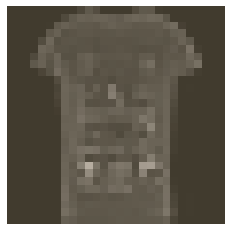

In [ ]:
# result 
ii=7

sample_list=np.where(testset.test_labels==0)  
image=testset[sample_list[0][ii]][0]
label=testset[sample_list[0][ii]][1]
output = model(image.view(-1,1,28,28))
imshow(image);
print('ground truth: {}'.format(label))
print('prediction  : {}'.format(torch.round(output)))

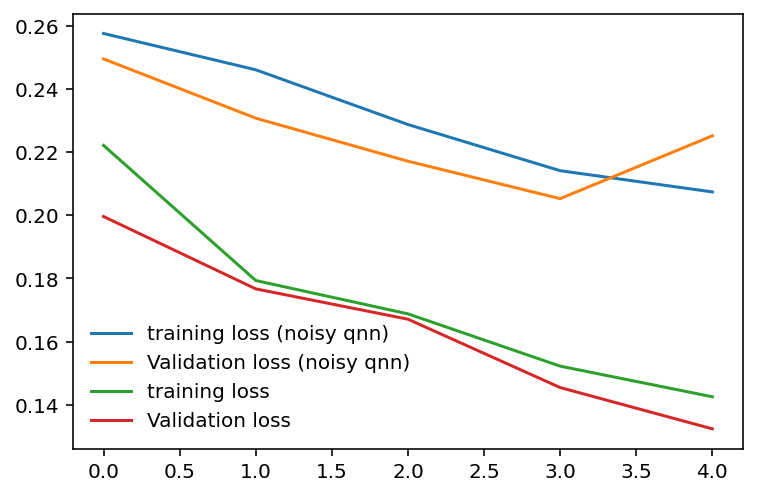

In [24]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt

plt.plot(train_losses_noisy, label='training loss (noisy qnn)')
plt.plot(test_losses_noisy, label='Validation loss (noisy qnn)')
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)